# Phase 3 Data Science Training Notebook

In [65]:
import pandas as pd
import numpy as np
from functions import*

## Exploratory Data Analysis

In [66]:
folder='cifar-10-batches\\' # folder name that contains cifar-10 files
# training,test and name variables 
train_batch1=unpickle(folder+'data_batch_1')
test=unpickle(folder+'test_batch')
label_names=unpickle(folder+'batches.meta')['label_names']


In [67]:
# display shape of dataset
ShapeOfData='variable: train_batch1 %s\n'%str(type(train_batch1))
ShapeOfData+='-------------------------------------\n'
ShapeOfData+=f'{"key": <13} size'+f'{"": <11}dtype\n' 
ShapeOfData+=f'{"---": <13} ----'+f'{"": <11}-----\n'
for key in train_batch1.keys():
    string=f'{key: <13} %s'%str(np.shape(train_batch1[key]))
    ShapeOfData+=f'{string: <29}%s'%str(type(train_batch1[key]))
    ShapeOfData+='\n'
print(ShapeOfData)

variable: train_batch1 <class 'dict'>
-------------------------------------
key           size           dtype
---           ----           -----
batch_label   ()             <class 'str'>
labels        (10000,)       <class 'list'>
data          (10000, 3072)  <class 'numpy.ndarray'>
filenames     (10000,)       <class 'list'>



In [68]:
# store training batches (1 to 5) in one variable
# reshape rgb data 2d (nx3072) array to 4d (nx32x32x3) for both test and training data
train_batches=[]
for num in range(1,6):
    dict=unpickle(folder+'data_batch_'+str(num))
    dict['data']=np.reshape(dict['data'],(10000,3,32,32))   
    dict['data']=np.transpose(dict['data'],[0,2,3,1])
    # remove keys that is unnecessary in this analysis
    dict.pop('batch_label')
    dict.pop('filenames')
    train_batches.append(dict)
# remove keys that is unnecessary in this analysis
test.pop('batch_label')
test.pop('filenames')
test['data']=np.reshape(test['data'],(10000,3,32,32))  
test['data']=np.transpose(test['data'],[0,2,3,1])

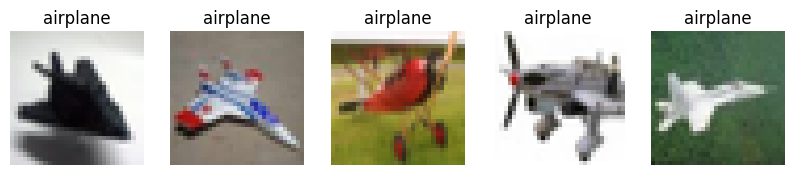

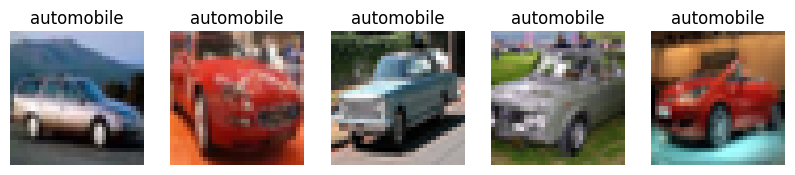

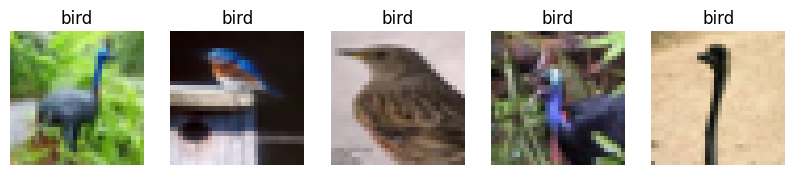

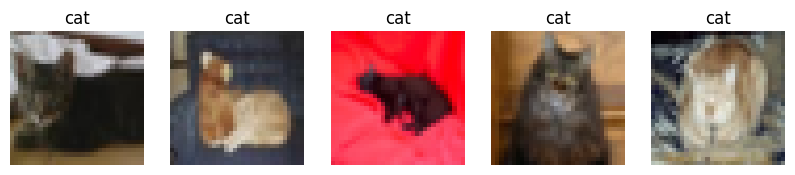

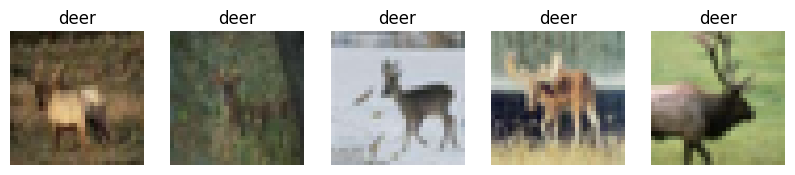

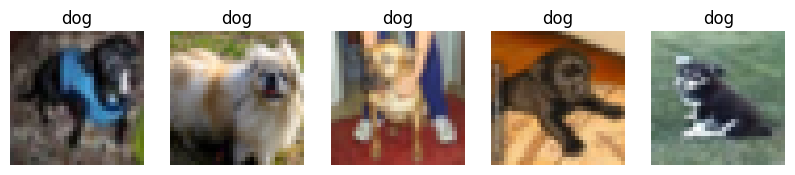

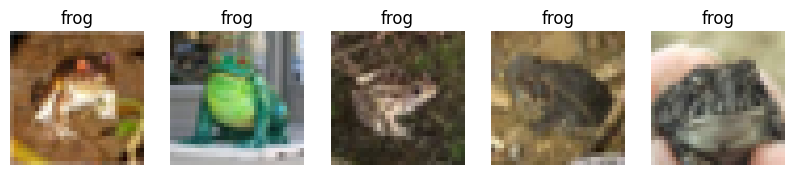

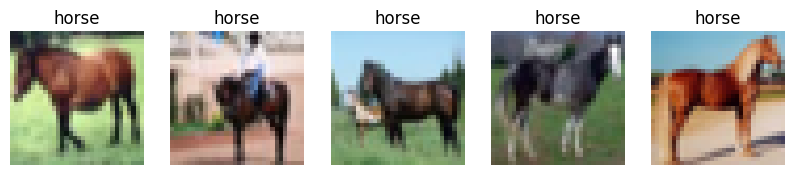

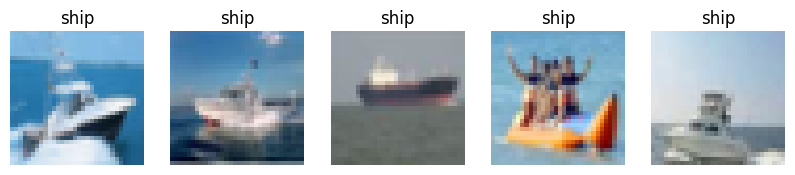

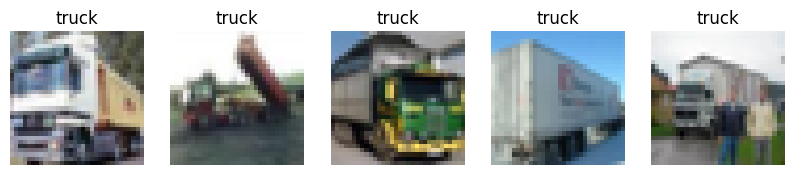

In [69]:
# render first 5 images in batch1 training set for each label
from PIL import Image
import matplotlib.pyplot as plt

train=train_batches[0]
for label in range(10):
    fig,ax=plt.subplots(1,5,figsize=(10, 10))
    num=0
    for idx in np.where(np.array(train['labels'])==label)[0][0:5]:
        ax[num].imshow(train['data'][idx])
        ax[num].set_title(label_names[label])
        ax[num].axis('off')
        num+=1   

In [70]:
# This function outputs list of zeros and ones for each batch, 1 if the label matches the element in the list and 0 otherwise.
def my_label_choice(label):
    train_y_batches=[]
    for batch in train_batches:
        train_y_batches.append(np.array(train['labels'])==label_names.index(label))
    return train_y_batches,np.array(test['labels'])==label_names.index(label)
label_choice='dog'    

Label dog will be chosen in this analysis to determine the probability that there is dog in the images for testing our model

# Data Processing

In [71]:
# split training batches to label and image batches
train_images_batches = [train['data'] for train in train_batches]
train_labels_batches = np.array([train['labels'] for train in train_batches])
# combine batches to one batch
train_labels_combined=np.reshape(train_labels_batches,(50000))
train_images_combined=np.reshape(train_images_batches,(50000,32,32,3))
# get 10000 training and 2000 test samples
train_labels,train_images=get_sample(train_labels_combined,train_images_combined,40000)
test_labels,test_images=get_sample(np.array(test['labels']),test['data'],8000)

# Data Modelling

In [72]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks

In [73]:
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [74]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(train_images, train_labels, epochs=50, validation_data=(test_images,test_labels), 
callbacks=[stop_early,ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal drop out ratio is {best_hps.get('dropout')}, the optimal number of units in the last densely-connected 
layer is {best_hps.get('units')} and the optimal learning rate for the optimizeris {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json
INFO:tensorflow:Oracle triggered exit

The optimal drop out ratio is 0.15, the optimal number of units in the last densely-connected 
layer is 192 and the optimal learning rate for the optimizeris 0.001.



In [75]:
import os.path
import json
# check the history alredy exist
if os.path.isfile('output\history'):
    #load the model
    history= json.load(open('output\history', 'r'))

    # print the result
    val_acc_per_epoch = history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,)) 
else:
    # Build the model with the optimal hyperparameters and train it on the data for 80 epochs
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(train_images, train_labels, epochs=80, validation_data=(test_images,test_labels))

    # save model
    # create directory and Save it under the form of a json file
    os.mkdir('output')
    json.dump(history.history, open('output\history', 'w'))
    
    # print the result
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))    

Best epoch: 70


In [76]:
# check if the model already exist
if os.path.isfile('output\my_model'):
    #load the model
    model = tf.keras.models.load_model('output\my_model')
else:
    # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
    hypermodel = tuner.hypermodel.build(best_hps)

    # Retrain the model
    hypermodel.fit(train_images, train_labels, epochs=best_epoch)

    # save model
    hypermodel.save('output\my_model', save_format="h5")

In [78]:
# result
eval_result = hypermodel.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

250/250 [==============================] - 2s 6ms/step - loss: 0.8277 - accuracy: 0.7374
[test loss, test accuracy]: [0.8277215361595154, 0.737375020980835]


1/1 [==============================] - 0s 21ms/step
This image belongs to automobile with a 100.00 percent confidence.


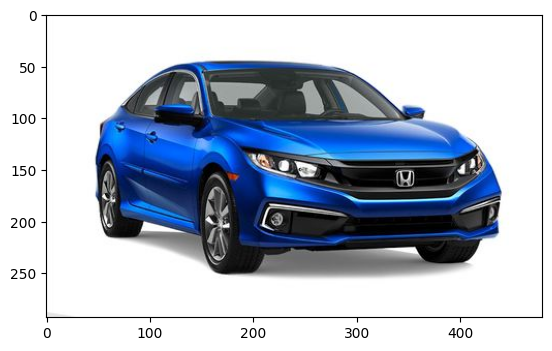

In [93]:
import requests
from io import BytesIO

# bring dog image and try on prediciton model
response = requests.get('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/2019-honda-civic-sedan-1558453497.jpg?crop=1xw:0.9997727789138833xh;center,top&resize=480:*')
img = Image.open(BytesIO(response.content))
img=np.array(img)
plt.imshow(img)
label,percent=predict(hypermodel,img,'automobile')
# print the result
print("This image belongs to automobile with a {:.2f} percent confidence."
    .format(percent))